## Investigate effective redshift distribution for spurious IA signal

In [1]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import locate
import time
import pyccl as ccl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)

In [2]:
# paths to required files
data_dir = '/home/b7009348/WGL_project/DES-data/'
lens_file = data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_Zs = data_dir+'mof_BPZ_(stacking).fits'
im3_file_full = data_dir+'y1_im3_shapes_matched.fits'
mcal_file_full = data_dir+'y1_mcal_shapes_matched.fits'

In [3]:
# load in im3 data 
with fits.open(im3_file_full) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
del data

# load in mcal data
with fits.open(mcal_file_full) as hdu:
    data = hdu[1].data
    mcal_weight = data['R11']
del data

# load in z_mc for all sources
with fits.open(source_Zs) as hdu:
    data = hdu[1].data
    source_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
    
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
source_zmc = source_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

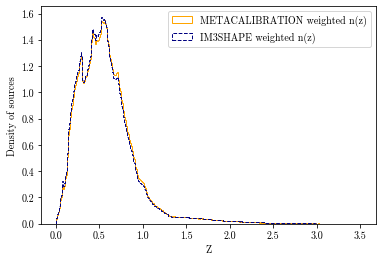

In [4]:
nbins = 500

mcal_counts, mcal_bins = np.histogram(source_zmc, bins=nbins, weights=mcal_weight)
im3_counts, im3_bins = np.histogram(source_zmc, bins=nbins, weights=im3_weight)

plt.figure()
plt.hist(mcal_bins[:-1], mcal_bins, weights=mcal_counts, density=True, histtype='step', color='orange', linestyle='-', linewidth=1)
plt.hist(im3_bins[:-1], im3_bins, weights=im3_counts, density=True, histtype='step', color='navy', linestyle='--', linewidth=1)
plt.legend(labels=('METACALIBRATION weighted n(z)', 'IM3SHAPE weighted n(z)'))
plt.xlabel('Z')
plt.ylabel('Density of sources')
plt.savefig('effective_n(z)_comparison.png', dpi=300)

## Run redshift distributions through CCL pipeline for theoretical $\gamma_{t}$
- Values for cosmology taken from

In [5]:
with fits.open(lens_file) as hdu:
    data = hdu[1].data
    lens_z = data['ZREDMAGIC']
    w_l = data['WEIGHT']
del data

lens_dndz, lens_bins = np.histogram(lens_z, bins=nbins, weights=w_l)

# Define cosmology

cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

mcal_z = mcal_bins[:-1]
mcal_dndz = mcal_counts

im3_z = im3_bins[:-1]
im3_dndz = im3_counts

lens_z = lens_bins[:-1]

theta_range = np.logspace(np.log10(2.5), np.log10(250), 20) * 1.0/60

b = 1.6*np.ones([nbins])

In [6]:
lensTracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(lens_z, lens_dndz), bias=(lens_z, b))
im3Tracer = ccl.WeakLensingTracer(cosmo, dndz=(im3_z,im3_dndz))
mcalTracer = ccl.WeakLensingTracer(cosmo, dndz=(mcal_z,mcal_dndz))

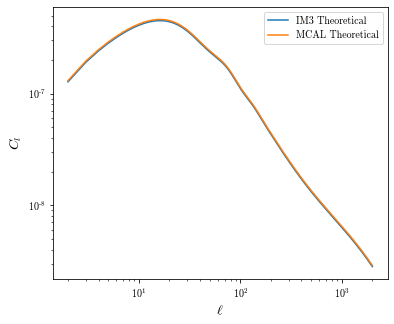

In [40]:
ell = np.arange(2,2000)

im3_aps = ccl.angular_cl(cosmo, lensTracer, im3Tracer, ell)
mcal_aps = ccl.angular_cl(cosmo, lensTracer, mcalTracer, ell)

plt.figure(figsize=[6,5])
plt.plot(ell, im3_aps)
plt.plot(ell, mcal_aps)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{l}$', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14)
plt.legend(['IM3 Theoretical', 'MCAL Theoretical'])
plt.savefig('theoretical_APS.png', dpi=300)

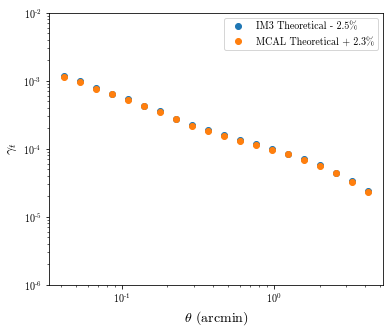

In [43]:
sig_mcal = 0.023
sig_im3 = 0.025

im3_gammat = ccl.correlation(cosmo, ell, im3_aps, theta_range, type='NG') * (1+sig_im3)
mcal_gammat = ccl.correlation(cosmo, ell, mcal_aps, theta_range, type='NG') * (1-sig_mcal)

plt.figure(figsize=[6,5])
plt.plot(theta_range, im3_gammat, linewidth=0, marker='o')
plt.plot(theta_range, mcal_gammat, linewidth=0, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-6, 1e-2])
plt.ylabel(r'$\gamma_{t}$', fontsize=14)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.legend([r'IM3 Theoretical + 2.5%', 'MCAL Theoretical - 2.3%'])
plt.savefig('theoretical_gammat_multi_shift.png', dpi=300)

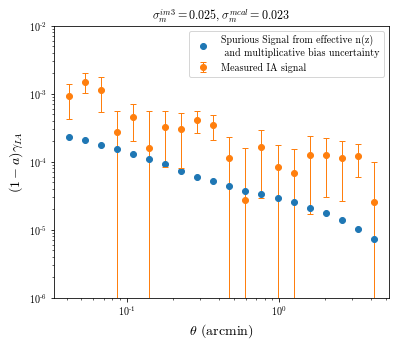

In [44]:
real_values = np.load(data_dir+'ia_full_values.npz')
jackknife_values = np.load(data_dir+'ia_jackknife_values.npz')

spurious_signal = (im3_gammat-mcal_gammat) / (real_values['boost'] - 1 + real_values['F'])

plt.figure(figsize=[6,5])
plt.plot(theta_range, spurious_signal, linewidth=0, marker='o')
plt.errorbar(theta_range, real_values['IA'], yerr=jackknife_values['IA_err'], linewidth=0, marker='o', elinewidth=1, capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-6, 1e-2])
plt.ylabel(r'$(1-a)\gamma_{IA}$', fontsize=14)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.title(r'$\sigma_{m}^{im3}=%g, \sigma_{m}^{mcal}=%g$'%(sig_im3, sig_mcal))
plt.legend(['Spurious Signal from effective n(z) \n and multiplicative bias uncertainty', 'Measured IA signal'])
plt.savefig('IA_vs_effective(nz)+multi_bias.png', dpi=300)